# Assignment 2: Classification
Goal: compare the Naive Bayes (NB) model to Logistic Regression (LR) on data with categorical attributes. 
- train/fit an NB and an LR model on the [Car Evaluation data set](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) 
- compare their performance by looking how well they predict in terms of 0/1-loss (misclassification rate, error percentage) 

In [34]:
import numpy as np
import pandas as pd
import pickle

import numpy as np
import pandas as pd
import random
from tqdm import tqdm
from statsmodels.stats.outliers_influence import variance_inflation_factor

### sklearn
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

### plotting
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
%config InlineBackend.figure_format ='retina'

# Data
### import data

In [4]:
file = '../data/car.data.txt'
myfile = open(file, 'r') 
mydata = []
for line in myfile:
    row = line.strip().split(',') 
    if row[6] == 'unacc':
        row[6] = 'Negative'
    else:
        row[6] = 'Positive' 
    mydata.append(row)

In [5]:
attr = ['buying','maint','doors','persons','lug_boot','safety','outcome']
df = pd.DataFrame(mydata, columns= attr)

### EDA
Possible Values:

In [6]:
for col in df:
    print(col,df[col].unique())

buying ['vhigh' 'high' 'med' 'low']
maint ['vhigh' 'high' 'med' 'low']
doors ['2' '3' '4' '5more']
persons ['2' '4' 'more']
lug_boot ['small' 'med' 'big']
safety ['low' 'med' 'high']
outcome ['Negative' 'Positive']


In [7]:
n = int(df.shape[0]/2) # train/test size
q = int(df.shape[1]-1) # num of features
print(n,q)

864 6


# Model
### Naive Bayes maximum likelihood estimation

In [8]:
def train_NB(X_train, X_test, y_train, y_test, a): 
    ### a is the smoothing factor
    nb = CategoricalNB(alpha = a) # train naive bayes model
    y_pred = nb.fit(X_train, y_train).predict(X_test)
    loss = (y_test!= y_pred).sum()/n # calculate 0/1-loss
    return loss

### Logistic regression conditional likelihood maximization


In [9]:
def train_LG(X_train, X_test, y_train, y_test, col = q, p='none'): 
    ### p is for regularization, col is the number of features to select
    X_train = X_train[:,0:col] # select features, default is selecting all the features
    X_test = X_test[:,0:col]
    onehot = OneHotEncoder(handle_unknown='ignore')
    onehot.fit(X_train)
    X_train = onehot.transform(X_train)
    X_test = onehot.transform(X_test)
    lg = LogisticRegression(random_state=2019, penalty = p) # train naive bayes model
    y_pred = lg.fit(X_train, y_train).predict(X_test)
    loss = (y_test!= y_pred).sum()/n # calculate 0/1-loss
    return loss

## Training
We are going to train the following models
- 'NB_1': Naive Bayes Model with Laplace smoothing parameter α = 1
- 'NB_0.1': Naive Bayes Model with Laplace smoothing parameter α = 0.1
- 'NB_10': Naive Bayes Model with Laplace smoothing parameter α = 10
- 'LR_full': Logistic Regression with all six variables, without regularization
- 'LR_2': Logistic Regression with only price variables('buying', 'maint') , without regularization
- 'LR_full_l2': Logistic Regression with all six variables, with L2 regularization (regularization factor C = 1)

### Train  all the models for a certain random train/test split

In [27]:
models = ['NB_1','NB_0.1','NB_10','LR_full','LR_2','LR_full_l2']

In [10]:
def train_once():
    ### This function is for training the all the models for a certain random train/test split
    results = pd.DataFrame(np.nan, index=np.arange(1,n+1), columns=models) #temp results for this train
    for i in range(n):
        X_tr = X_train_cat[:i+1]
        y_tr = y_train[:i+1]
        try:
            results.iloc[i+1,0] = train_NB(X_tr, X_test_cat, y_tr, y_test, 1)
        except:
            pass
        try:
            results.iloc[i+1,1] = train_NB(X_tr, X_test_cat, y_tr, y_test, 0.1)
        except:
            pass
        try:
            results.iloc[i+1,2] = train_NB(X_tr, X_test_cat, y_tr, y_test, 10)
        except:
            pass
        try:
            results.iloc[i+1,3] = train_LG(X_tr, X_test_cat, y_tr, y_test, q)
        except:
            pass
        try:
            results.iloc[i+1,4] = train_LG(X_tr, X_test_cat, y_tr, y_test, 2)
        except:
            pass
        try:
            results.iloc[i+1,5] = train_LG(X_tr, X_test_cat, y_tr, y_test, q, 'l2')
        except:
            pass
    return results

### Train M times to smooth the results

In [11]:
### results dataframe
results = pd.DataFrame(0, index=np.arange(1,n+1), columns=models)

In [14]:
M = 20 # train M times
enc = OrdinalEncoder() # convert features into dummies numbers for model training
for i in tqdm(range(M)):
    X_train, X_test, y_train, y_test = train_test_split(df[attr[0:6]],df.outcome,train_size=0.5,random_state=M)
    X_train_cat = enc.fit_transform(X_train) # 'cat' for category (dummy numbers)
    X_test_cat = enc.transform(X_test)
    temp = train_once() # temp results
    results = results + temp # sum up the results
results = results / M  # get the average results over M runs

100%|██████████| 20/20 [13:58<00:00, 41.08s/it]


In [15]:
### save results
RESULTS = "results.pkl"

with open(RESULTS, "wb") as dataset_outfile:
    pickle.dump(results, dataset_outfile)

In [16]:
### import results
RESULTS = "results.pkl"

with open(RESULTS, "rb") as dataset_infile:
        results = pickle.load(dataset_infile)

# Results
### Show untrainable runs

In [17]:
results[0:10]

,NB_1,NB_0.1,NB_10,LG_full,LG_2,LG_full_l2
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,0.474942,0.615451,0.693924
6,NaN,NaN,NaN,0.350405,0.563194,0.445544
7,NaN,NaN,NaN,0.399306,0.535417,0.389931
8,NaN,NaN,NaN,0.367998,0.546991,0.343692
9,0.356597,0.354456,0.313715,0.356134,0.530671,0.314410
10,0.331771,0.330324,0.320081,0.338426,0.368287,0.313194


### Average 1/0 Error for models ['NB_1', 'NB_0.1', 'NB_10', 'LG_full', 'LG_2', 'LG_full_l2'] over 20 runs

In [18]:
colors = ['salmon','gold','red','c','lightblue','b']
linestyles = ['dashed','solid','dotted','dashed','solid','dotted'] 

Ref
- [colors](https://matplotlib.org/tutorials/colors/colors.html)
- [type](https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/linestyles.html)

Average 1/0 Error for models ['NB_1', 'NB_0.1', 'NB_10', 'LR_full', 'LR_2', 'LR_full_l2'] over 20 runs. 


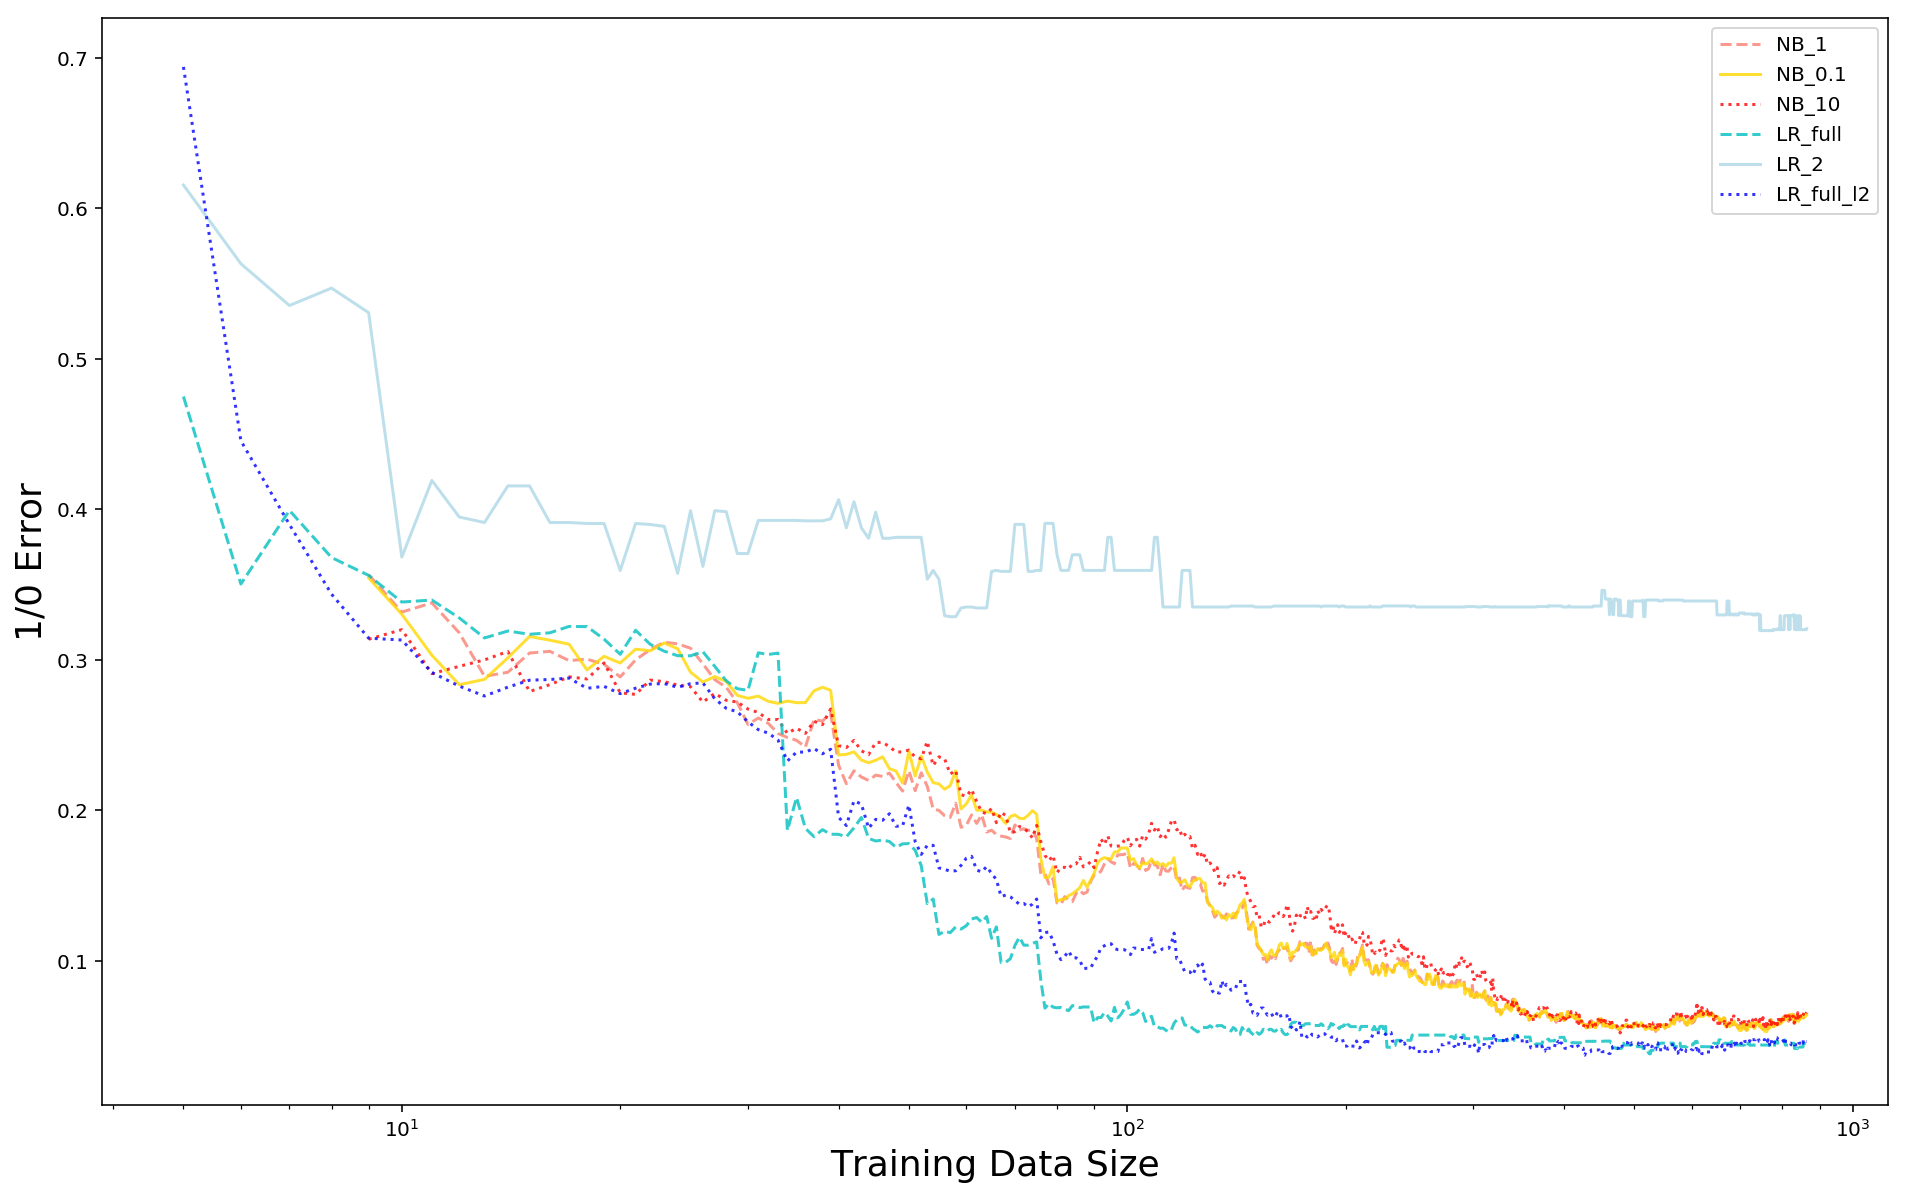

In [29]:
f, ax = plt.subplots(figsize=(16,10))
ax.set(xscale="log")
plt.xlabel("Training Data Size", fontsize=18)
plt.ylabel("1/0 Error", fontsize=18)
for i in range(q):
    plt.plot(results.iloc[:,i], color = colors[i], linestyle = linestyles[i], alpha = 0.8)
plt.legend(models)
print("Average 1/0 Error for models {:s} over {:d} runs. ".format(str(models),M))

In [20]:
results.iloc[9::100, :]

,NB_1,NB_0.1,NB_10,LG_full,LG_2,LG_full_l2
10,0.331771,0.330324,0.320081,0.338426,0.368287,0.313194
110,0.163021,0.165683,0.189468,0.056424,0.381424,0.106829
210,0.107002,0.106771,0.119097,0.056481,0.335127,0.043287
310,0.078935,0.078935,0.090336,0.048264,0.335417,0.044502
410,0.062905,0.062905,0.065278,0.045718,0.335127,0.043229
510,0.057813,0.057928,0.058044,0.043056,0.339120,0.044387
610,0.064468,0.064468,0.068056,0.046586,0.339120,0.043229
710,0.056250,0.056192,0.057639,0.042824,0.330498,0.046470
810,0.060880,0.060937,0.063426,0.044097,0.329340,0.046644


# Compare NB_1 and LG_full on full train dataset created in the last run

In [21]:
onehot = OneHotEncoder(handle_unknown='ignore')
onehot.fit(X_train_cat)
X_train_one_hot = onehot.transform(X_train_cat)
X_test_one_hot = onehot.transform(X_test_cat)

In [22]:
nb = CategoricalNB()
prob_nb = nb.fit(X_train_cat, y_train).predict_proba(X_train_cat)
lg = LogisticRegression(random_state=2019, penalty = 'none') 
prob_lg = lg.fit(X_train_one_hot, y_train).predict_proba(X_train_one_hot) 

### Check extreme probablities

In [23]:
sum([(pair[1] - pair[0])**2 for pair in prob_nb])

522.7040245499987

In [24]:
sum([(pair[1] - pair[0])**2 for pair in prob_lg])

751.16528667914

LG has more extreme predicted probalities

### Check overfitting

In [25]:
print('Naive Bayes Acuracy: Train    Test')
nb.score(X_train_cat, y_train), nb.score(X_test_cat, y_test)

Naive Bayes Acuracy: Train    Test


(0.9409722222222222, 0.9386574074074074)

In [110]:
### 0/1 -errors
1- 0.9409722222222222, 1-0.9386574074074074

(0.05902777777777779, 0.06134259259259256)

In [26]:
print('Logistic Acuracy: Train    Test')
lg.score(X_train_one_hot, y_train), lg.score(X_test_one_hot, y_test)

Logistic Acuracy: Train    Test


(0.9479166666666666, 0.9571759259259259)

In [103]:
### 0/1 -errors
1-0.9479166666666666, 1- 0.9571759259259259

(0.05208333333333337, 0.04282407407407407)

### Confusion Matrix

In [31]:
class_names=['Negative','Postive'] # name  of classes

Text(0.5,15,'Predicted label')

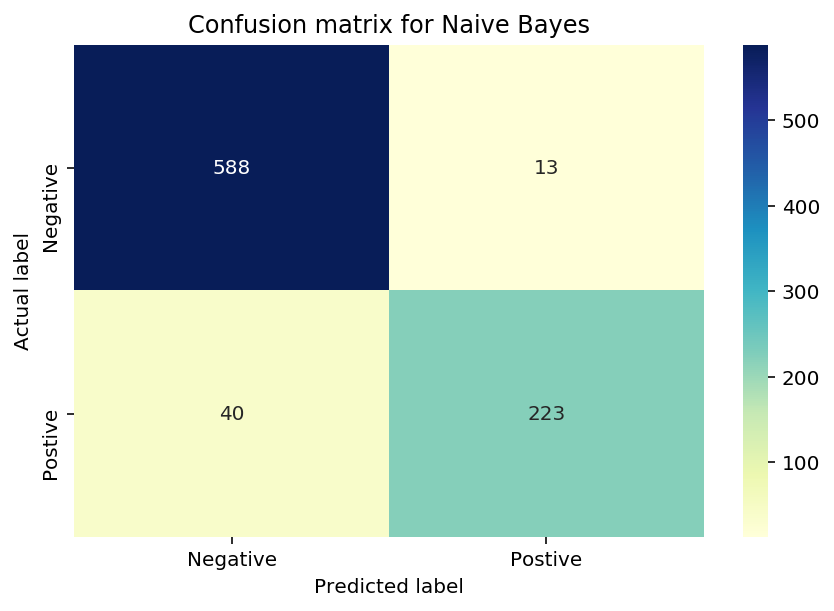

In [32]:
y_pred = nb.predict(X_test_cat)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(pd.DataFrame(cnf_matrix, index = class_names, columns= class_names), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion matrix for Naive Bayes')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Text(0.5,15,'Predicted label')

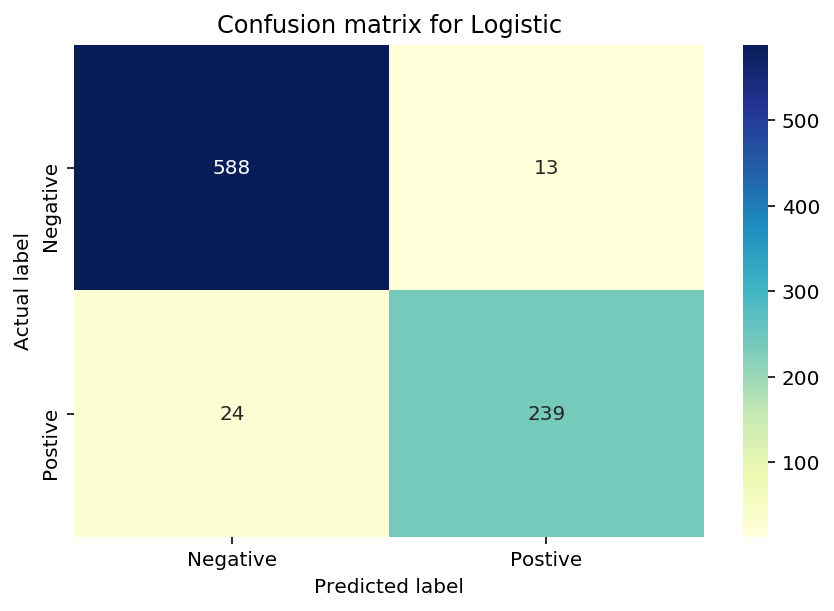

In [33]:
y_pred = lg.predict(X_test_one_hot)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(pd.DataFrame(cnf_matrix, index = class_names, columns= class_names), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion matrix for Logistic')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Correlation

In [93]:
door = X_train[['doors']].replace('5more', 5)
per = X_train[['persons']].replace('more', 5)

pricemap = {'vhigh':4, 'high' :3,'med' :2,'low':1}
lugmap ={'small':1, 'med':2, 'big':3} 
safetymap = {'low':1, 'med' :2,'high':3}

buying = X_train['buying'].map(pricemap)
maint = X_train['maint'].map(pricemap)
lug_boot = X_train['lug_boot'].map(lugmap)
safety = X_train['safety'].map(safetymap)

In [96]:
cor = pd.DataFrame({'door':door.astype(int).values.flatten(), 'per':per.astype(int).values.flatten(),
                   'buying':buying,'maint':maint,'lug_boot':lug_boot,'safety':safety})

In [97]:
cor.corr()

,buying,door,lug_boot,maint,per,safety
buying,1.000000,0.017391,0.053936,-0.002390,0.022161,0.013661
door,0.017391,1.000000,-0.000012,0.008427,-0.040273,0.004465
lug_boot,0.053936,-0.000012,1.000000,0.007664,0.008589,0.029644
maint,-0.002390,0.008427,0.007664,1.000000,0.015690,-0.029156
per,0.022161,-0.040273,0.008589,0.015690,1.000000,0.020402
safety,0.013661,0.004465,0.029644,-0.029156,0.020402,1.000000


### Test how LR performs on ordinal categorical features

In [102]:
lg_try = LogisticRegression(random_state=2019) 
lg_try.fit(cor, y_train).score(cor, y_train)

0.8854166666666666